# FVCOM Grid Node Checker Demo
**Author: Jun Sasaki | Created: 2025-09-14 Updated: 2025-09-18**

**Purpose:** Visualize FVCOM grid nodes using xfvcom's core plotting functionality

This notebook demonstrates how to:
- Load FVCOM grid using FvcomInputLoader
- Use FvcomPlotter with FvcomPlotOptions for visualization
- Display node markers and numbers using make_node_marker_post
- Highlight specific nodes of interest
- Export node coordinate information

## Setup and Imports

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles, OSM

# Import xfvcom modules
from xfvcom import (
    FvcomInputLoader,
    FvcomPlotter,
    FvcomPlotConfig,
    FvcomPlotOptions,
    make_node_marker_post,
)

# Create output directory for saved figures
output_dir = Path("PNG")
output_dir.mkdir(exist_ok=True)

print("Setup complete!")

Setup complete!


## 1. Define Grid File Path and Load Grid
Load the FVCOM grid file to get mesh structure and node coordinates

In [2]:
# Define path to your grid file
grid_file = Path("~/Github/TB-FVCOM/goto2023/input/TokyoBay18_grd.dat").expanduser()

# UTM zone for Tokyo Bay (adjust for your region)
utm_zone = 54

# Check if file exists
if grid_file.exists():
    print(f"✓ Grid file found: {grid_file}")
    print(f"  File size: {grid_file.stat().st_size / 1024:.1f} KB")
else:
    print(f"✗ Grid file not found: {grid_file}")
    print("  Please update the path to your FVCOM grid file")

# Load grid using FvcomInputLoader
loader = FvcomInputLoader(
    grid_path=grid_file,
    utm_zone=utm_zone,
    add_dummy_time=False,  # We don't need dummy time for this
    add_dummy_siglay=False  # We don't need dummy sigma layers
)

# Get the dataset and grid object
grid_ds = loader.ds
grid_obj = loader.grid

print(f"\nGrid loaded successfully")
print(f"Number of nodes: {grid_obj.node}")
print(f"Number of elements: {grid_obj.nele}")
print(f"Coordinate range:")
print(f"  Longitude: {grid_ds.lon.min().values:.3f} - {grid_ds.lon.max().values:.3f}")
print(f"  Latitude: {grid_ds.lat.min().values:.3f} - {grid_ds.lat.max().values:.3f}")

✓ Grid file found: /home/pj24001722/ku40000343/Github/TB-FVCOM/goto2023/input/TokyoBay18_grd.dat
  File size: 265.8 KB

Grid loaded successfully
Number of nodes: 3210
Number of elements: 5645
Coordinate range:
  Longitude: 139.629 - 140.112
  Latitude: 34.972 - 35.695


## 2. Initialize Plotter
Create FvcomPlotter instance for visualization

In [3]:
# Create plotter for visualization
cfg = FvcomPlotConfig()
plotter = FvcomPlotter(grid_ds, cfg)

print("FvcomPlotter initialized")

FvcomPlotter initialized


## 3. Display All Nodes with Markers
Show markers at all node positions using make_node_marker_post

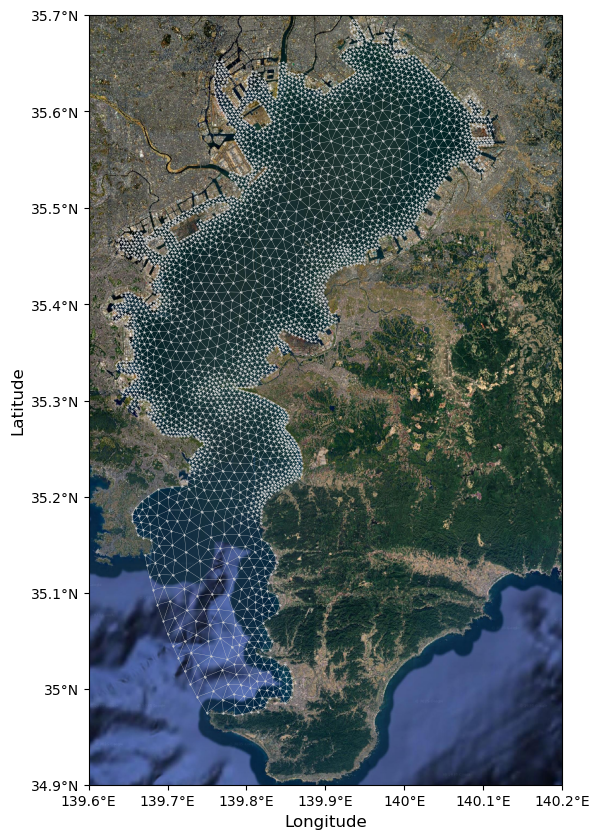

All nodes visualization saved to PNG/all_nodes_markers.png


In [4]:
# Display all nodes with markers (no numbers for performance)
# Create array of all node indices (1-based for FVCOM convention)
all_nodes = np.arange(1, grid_obj.node + 1)

# Define marker styling for all nodes
marker_kwargs = {
    "marker": "o", 
    "color": "lightgray", 
    "markersize": 0.5,  # Small size for all nodes
    "zorder": 4
}

# Create post-processing function for all nodes
pp_all_nodes = make_node_marker_post(
    all_nodes,
    plotter,
    marker_kwargs=marker_kwargs,
    text_kwargs=None,  # No text labels for performance
    index_base=1,
    respect_bounds=True,  # Only show nodes within view bounds
)

# Plot options
opts = FvcomPlotOptions(
    figsize=(12, 10),
    add_tiles=True,
    tile_provider=GoogleTiles(style="satellite"),
    mesh_color="lightgray",
    mesh_linewidth=0.2,
    title="All Grid Nodes",
)

# Create the plot
ax = plotter.plot_2d(da=None, post_process_func=pp_all_nodes, opts=opts)

# Save figure
ax.figure.savefig(output_dir / "all_nodes_markers.png", dpi=300, bbox_inches='tight')
plt.show()
print("All nodes visualization saved to PNG/all_nodes_markers.png")

## 4. Display Specific Nodes with Numbers
Highlight and label specific nodes of interest

Valid nodes: [100, 200, 300, 500, 1000, 1500, 2000, 2500, 3000]


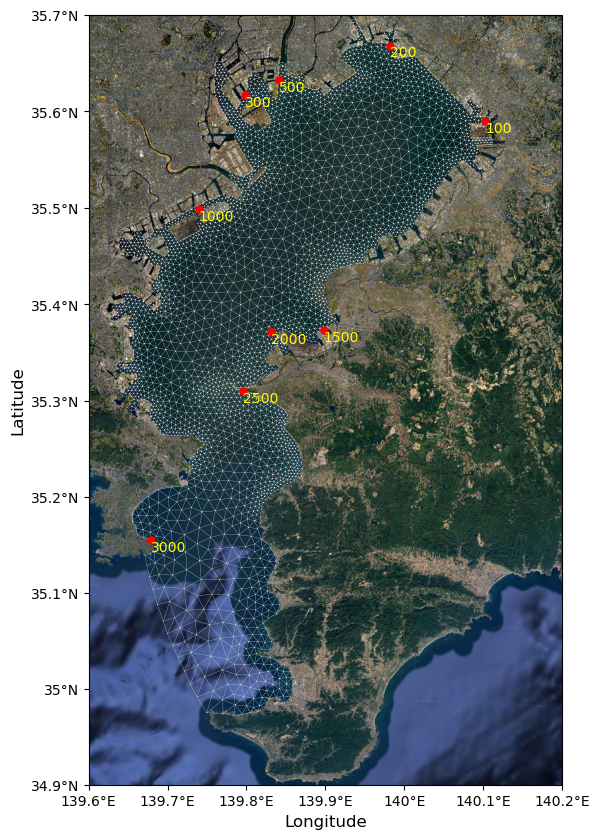

Specific nodes visualization saved to PNG/specific_nodes.png


In [5]:
# Define nodes of interest (one-based node numbers)
nodes_of_interest = [100, 200, 300, 500, 1000, 1500, 2000, 2500, 3000]

# Check if nodes are valid
valid_nodes = [n for n in nodes_of_interest if 1 <= n <= grid_obj.node]
invalid_nodes = [n for n in nodes_of_interest if n < 1 or n > grid_obj.node]

print(f"Valid nodes: {valid_nodes}")
if invalid_nodes:
    print(f"Invalid nodes (out of range): {invalid_nodes}")

# Define marker and text styling for specific nodes
mkw = {"marker": "o", "color": "red", "markersize": 5, "zorder": 5}
tkw = {"fontsize": 10, "color": "yellow", "ha": "left", "va": "top",
       "zorder": 6, "clip_on": True}

# Create post-processing function for specific nodes
pp_specific = make_node_marker_post(
    valid_nodes,
    plotter,
    marker_kwargs=mkw,
    text_kwargs=tkw,
    index_base=1,
    respect_bounds=False,  # Show all specified nodes
)

# Plot options with spcified background
opts = FvcomPlotOptions(
    figsize=(12, 10),
    add_tiles=True,
    tile_provider=GoogleTiles(style="satellite"),
    mesh_color="lightgray",
    mesh_linewidth=0.2,
    title="Specific Nodes Highlighted",
)

# Create the plot
ax = plotter.plot_2d(da=None, post_process_func=pp_specific, opts=opts)

# Save figure
ax.figure.savefig(output_dir / "specific_nodes.png", dpi=300, bbox_inches='tight')
plt.show()
print("Specific nodes visualization saved to PNG/specific_nodes.png")

## 5. Plot Nodes on Mesh Map (Zoomed View)
Similar to river input checker Section 5 - show nodes on zoomed map with satellite tiles

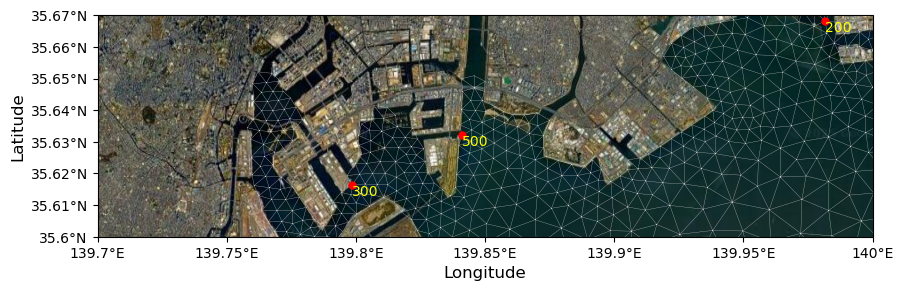

Nodes shown in this view: [200, 300, 500]
Nodes outside view bounds: [100, 1000, 1500, 2000, 2500, 3000]

To see all nodes regardless of bounds, set respect_bounds=False


In [6]:
# Set map domain for zoomed view (adjust these to your area of interest)
# Example: Focus on central Tokyo Bay
xlim = (139.72, 140.00)
ylim = (35.60, 35.67)

# Select subset of nodes for zoomed view
# You can define specific nodes or use a range
selected_nodes = [100, 200, 300, 500, 1000, 1500, 2000, 2500, 3000]

# Define marker and text styling
mkw = {"marker": "o", "color": "red", "markersize": 5, "zorder": 4}
tkw = {"fontsize": 10, "color": "yellow", "ha": "left", "va": "top",
       "zorder": 5, "clip_on": True}

# Create post-processing function
pp_zoomed = make_node_marker_post(
    selected_nodes,
    plotter,
    marker_kwargs=mkw,
    text_kwargs=tkw,
    index_base=1,
    respect_bounds=True,  # Only show nodes within xlim/ylim
)

# Plot options following river_input_checker style
opts = FvcomPlotOptions(
    figsize=(10, 12),
    add_tiles=True,
    tile_provider=GoogleTiles(style="satellite"),
    mesh_color="lightgray",
    mesh_linewidth=0.2,
    title="Node Locations on FVCOM Mesh (Zoomed View)",
    xlim=xlim,
    ylim=ylim,
)

# Create the plot
ax = plotter.plot_2d(da=None, post_process_func=pp_zoomed, opts=opts)

# Save figure
ax.figure.savefig(output_dir / "nodes_map_zoomed.png", dpi=300, bbox_inches='tight')
plt.show()

# Report which nodes are shown vs hidden
nodes_shown = []
nodes_hidden = []
for node_idx_1based in selected_nodes:
    node_idx_0based = node_idx_1based - 1
    if node_idx_0based < len(grid_ds.lon):
        lon = grid_ds.lon.values[node_idx_0based]
        lat = grid_ds.lat.values[node_idx_0based]
        if xlim[0] <= lon <= xlim[1] and ylim[0] <= lat <= ylim[1]:
            nodes_shown.append(node_idx_1based)
        else:
            nodes_hidden.append(node_idx_1based)

print(f"Nodes shown in this view: {nodes_shown}")
print(f"Nodes outside view bounds: {nodes_hidden}")
print("\nTo see all nodes regardless of bounds, set respect_bounds=False")

## 6. Combined Visualization
Show all nodes with specific nodes highlighted

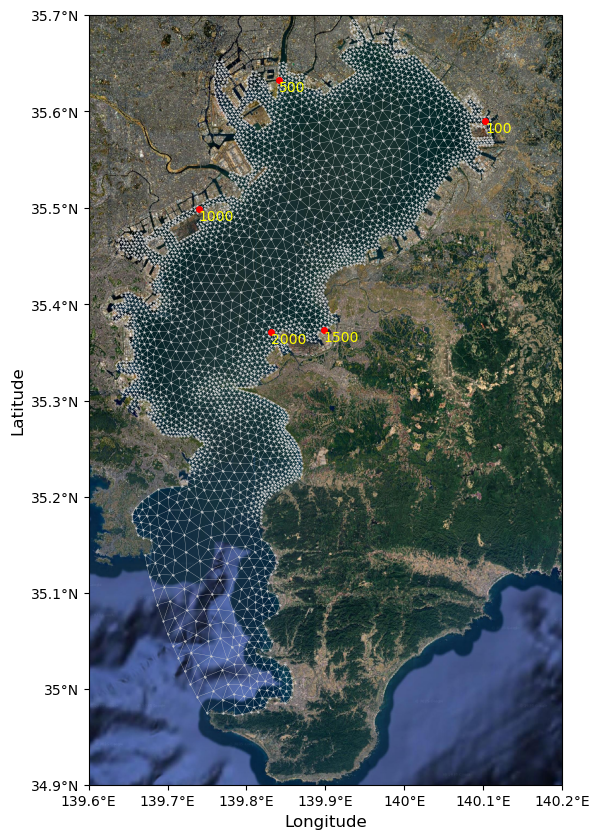

Combined visualization saved to PNG/combined_view.png


In [7]:
# Combine all nodes (small blue markers) with highlighted specific nodes (red with numbers)

# Define marker and text styling
mkw = {"marker": "o", "color": "red", "markersize": 4, "zorder": 5}
tkw = {"fontsize": 10, "color": "yellow", "ha": "left", "va": "top",
       "zorder": 6, "clip_on": True}
# Create a combined post-processing function
def combined_post_process(ax):
    # First, plot all nodes as small markers
    all_nodes_subset = np.arange(1, grid_obj.node + 1)
    pp_all = make_node_marker_post(
        all_nodes_subset,
        plotter,
        marker_kwargs={"marker": ".", "color": "lightgray", "markersize": 1, "zorder": 3},
        text_kwargs=None,
        index_base=1,
        respect_bounds=True,
    )
    pp_all(ax)
    
    # Then, highlight specific nodes with numbers
    highlight_nodes = [100, 500, 1000, 1500, 2000]
    pp_highlight = make_node_marker_post(
        highlight_nodes,
        plotter,
        marker_kwargs=mkw,
        text_kwargs=tkw,
        index_base=1,
        respect_bounds=True,
    )
    pp_highlight(ax)

# Plot options
opts = FvcomPlotOptions(
    figsize=(12, 10),
    add_tiles=True,
    tile_provider=GoogleTiles(style="satellite"),
    mesh_color="lightgray",
    mesh_linewidth=0.2,
    title="All Nodes with Highlighted Selection",
)

# Create the plot
ax = plotter.plot_2d(da=None, post_process_func=combined_post_process, opts=opts)

# Save figure
ax.figure.savefig(output_dir / "combined_view.png", dpi=300, bbox_inches='tight')
plt.show()
print("Combined visualization saved to PNG/combined_view.png")

## 7. Map View with All Nodes and Node Numbers

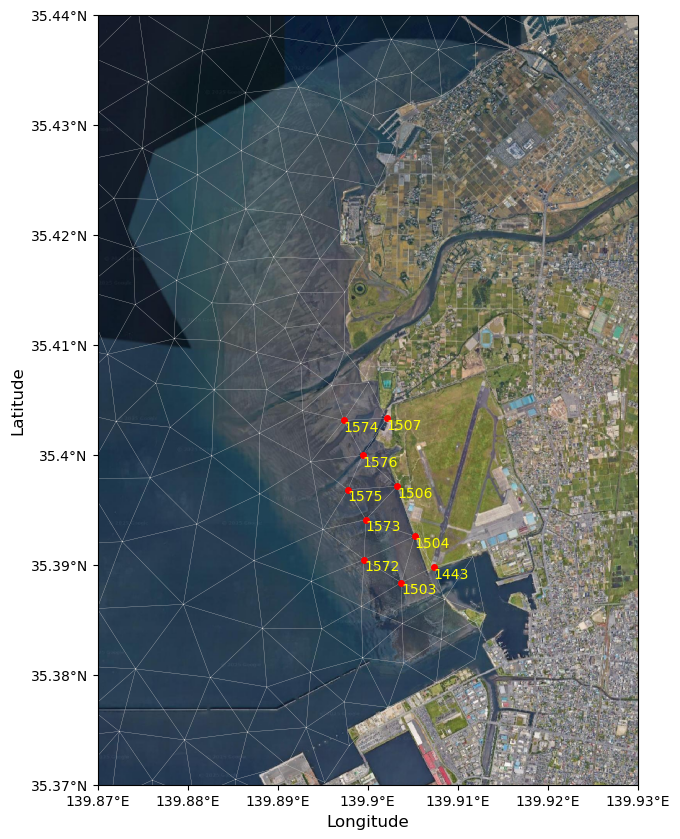

Map showing nodes and numbers; saved to PNG/nodes_num_map.png
Total nodes displayed: 10 out of 3210


In [8]:
# Create a full map view showing all nodes (or a subset for performance)
# Use every 50th node to avoid overcrowding

# Nodes to be plotted
#display_nodes = np.arange(1, grid_obj.node + 1)  # all nodes
display_nodes = [1443, 1503, 1504, 1506, 1507, 1572, 1573, 1574, 1575, 1576]  # specify 1-based node number list

# Create post-processing function that shows ALL selected markers
pp_node_num = make_node_marker_post(
    display_nodes,
    plotter,
    marker_kwargs={"marker": "o", "color": "red", "markersize": 4, "zorder": 4},
    text_kwargs={"fontsize": 10, "color": "yellow", "ha": "left", "va": "top", "zorder": 5, "clip_on": True},
    index_base=1,
    respect_bounds=True,  # Show all markers regardless of xlim/ylim
    marker_clip_buffer=-0.001,   # in degrees No buffer - strict clipping at boundaries
    text_clip_buffer=-0.001,  # in degrees No buffer - strict clipping at boundaries
)

# Full map extent
# xlim_node_num = (float(grid_ds.lon.min()), float(grid_ds.lon.max()))
# ylim_node_num = (float(grid_ds.lat.min()), float(grid_ds.lat.max()))
# Zoomed map extent
xlim_node_num = (139.87, 139.93)
ylim_node_num = (35.37, 35.44)

# Use GoogleTiles with moderate zoom for faster rendering
from cartopy.io.img_tiles import GoogleTiles

# Create tile provider with moderate resolution
tile_provider_hires = GoogleTiles(style="satellite")

# Plot options for full view
opts_node_num = FvcomPlotOptions(
    figsize=(12, 10),
    add_tiles=True,
    tile_provider=tile_provider_hires,
    mesh_color="lightgray",
    mesh_linewidth=0.2,
    title=f"Node Locations on FVCOM Mesh",
    xlim=xlim_node_num,
    ylim=ylim_node_num,
)

# Create the full map plot
ax_node_num = plotter.plot_2d(da=None, post_process_func=pp_node_num, opts=opts_node_num)

# Add tiles with moderate zoom level (15 for balance between quality and speed)
if hasattr(ax_node_num, 'add_image'):
    # Clear existing tiles first
    for artist in ax_node_num.artists[:]:
        artist.remove()
    # Add tiles with zoom level 15 (moderate resolution, faster loading)
    ax_node_num.add_image(tile_provider_hires, 15)

# Save figure
ax_node_num.figure.savefig(output_dir / "nodes_num_map.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"Map showing nodes and numbers; saved to PNG/nodes_num_map.png")
print(f"Total nodes displayed: {len(display_nodes)} out of {grid_obj.node}")

## 8. Calculate Total Area for Selected Nodes (Two Methods)

There are two methods for calculating node areas:
1. **Triangle-based method** (`calculate_node_area`): Sums areas of all triangular elements containing the specified nodes
2. **Median-dual control volume method** (`calculate_node_area_median_dual`): Uses FVCOM's standard median-dual control volumes

The median-dual method is the physically correct approach for FVCOM computations.

In [ ]:
# Calculate total area for the displayed nodes using BOTH methods
# The display_nodes list was defined in the previous cell
print(f"Selected nodes (1-based): {display_nodes}")

# Method 1: Triangle-based calculation (original, incorrect for FVCOM physics)
triangle_area_m2 = loader.calculate_node_area(display_nodes, index_base=1)
triangle_area_km2 = triangle_area_m2 / 1e6
triangle_area_ha = triangle_area_m2 / 1e4

print(f"\n=== Method 1: Triangle-based (simple geometric) ===")
print(f"Total area of triangular elements containing nodes:")
print(f"  {triangle_area_m2:,.0f} m²")
print(f"  {triangle_area_km2:.4f} km²")
print(f"  {triangle_area_ha:.2f} ha (hectares)")

# Method 2: Median-dual control volume calculation (FVCOM standard, correct)
median_dual_area_m2 = loader.calculate_node_area_median_dual(display_nodes, index_base=1)
median_dual_area_km2 = median_dual_area_m2 / 1e6
median_dual_area_ha = median_dual_area_m2 / 1e4

print(f"\n=== Method 2: Median-dual control volume (FVCOM physics) ===")
print(f"Total area of median-dual control volumes for nodes:")
print(f"  {median_dual_area_m2:,.0f} m²")
print(f"  {median_dual_area_km2:.4f} km²")
print(f"  {median_dual_area_ha:.2f} ha (hectares)")

# Compare the two methods
print(f"\n=== Comparison ===")
print(f"Difference: {abs(triangle_area_m2 - median_dual_area_m2):,.0f} m²")
print(f"Ratio (median-dual / triangle): {median_dual_area_m2 / triangle_area_m2:.4f}")

# Calculate individual control volumes for each node
print(f"\n=== Individual node control volumes (median-dual) ===")
for node in display_nodes[:5]:  # Show first 5 nodes
    cv_area = loader.calculate_node_area_median_dual([node], index_base=1)
    print(f"  Node {node}: {cv_area:,.0f} m² ({cv_area/1e6:.6f} km²)")

# Compare with total mesh area
print(f"\n=== For reference ===")
# Total mesh area using median-dual (correct)
total_md_area = loader.calculate_node_area_median_dual(None)  # All nodes
print(f"  Total mesh area (median-dual): {total_md_area/1e6:.2f} km²")
print(f"  Selected area percentage: {100 * median_dual_area_m2 / total_md_area:.4f}%")

## 9. Alternative: Using Standalone Function

You can also calculate node areas directly from a grid file without loading the full dataset.

In [10]:
# Alternative method: Use the standalone function for direct calculation
from xfvcom import calculate_node_area

# Example with a custom list of nodes
custom_nodes = [1000, 1001, 1002, 1003, 1004]

# Calculate area directly from grid file
area_direct = calculate_node_area(
    grid_file=grid_file,
    node_indices=custom_nodes,
    utm_zone=utm_zone,
    index_base=1  # Using 1-based indexing (FVCOM convention)
)

print(f"Custom node list: {custom_nodes}")
print(f"Total area: {area_direct:,.0f} m² ({area_direct/1e6:.4f} km²)")

# Example with zero-based indexing
# If you have node indices from a zero-based system (like Python arrays)
zero_based_nodes = [999, 1000, 1001, 1002, 1003]  # Same nodes as above but 0-based
area_zero_based = calculate_node_area(
    grid_file=grid_file,
    node_indices=zero_based_nodes,
    utm_zone=utm_zone,
    index_base=0  # Using 0-based indexing
)

print(f"\nZero-based node list: {zero_based_nodes}")
print(f"Total area: {area_zero_based:,.0f} m² (should be same as above)")
print(f"Areas match: {np.isclose(area_direct, area_zero_based)}")

Custom node list: [1000, 1001, 1002, 1003, 1004]
Total area: 1,179,511 m² (1.1795 km²)

Zero-based node list: [999, 1000, 1001, 1002, 1003]
Total area: 1,179,511 m² (should be same as above)
Areas match: True


## 10. Visualize Element Boundaries for Selected Nodes

Display the triangular element boundaries for selected nodes using polylines. This shows the actual area being calculated by the `calculate_node_area` function.

Found 42 boundary edges for selected nodes


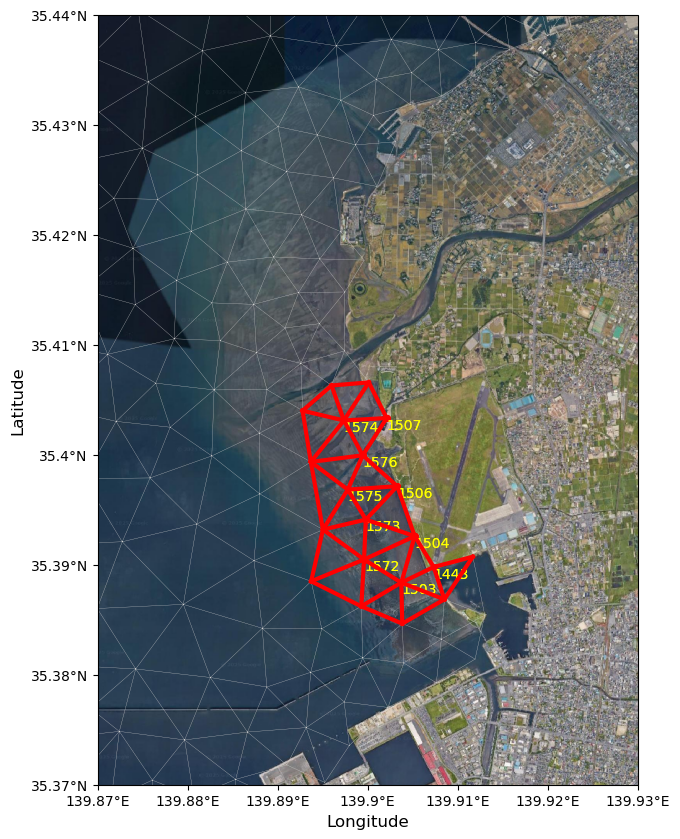


Nodes displayed: [1443, 1503, 1504, 1506, 1507, 1572, 1573, 1574, 1575, 1576]
Number of boundary edges: 42
Total area of elements: 2,039,705 m² (2.0397 km²)

First few boundary coordinates:
  Edge 0: (139.908514, 35.386857) to (139.903837, 35.384651)
  Edge 1: (139.905220, 35.392601) to (139.899594, 35.390480)
  Edge 2: (139.897356, 35.403123) to (139.893686, 35.399353)

Figure saved to PNG/nodes_with_boundaries.png


In [11]:
# Import the boundary visualization function
from xfvcom import make_element_boundary_post
import cartopy.crs as ccrs

# Get boundaries for display nodes
boundaries = loader.get_node_element_boundaries(display_nodes, index_base=1, return_as="lines")
print(f"Found {len(boundaries)} boundary edges for selected nodes")

# Create a function that draws boundaries directly
def draw_boundaries_directly(ax):
    """Draw boundaries directly on the axes after everything else."""
    # Draw each boundary line
    for boundary in boundaries:
        x_coords = [boundary[0][0], boundary[1][0]]
        y_coords = [boundary[0][1], boundary[1][1]]
        
        # Plot with high zorder to ensure visibility
        ax.plot(x_coords, y_coords,
                transform=ccrs.PlateCarree(),
                color='red',
                linewidth=3,
                linestyle='-',
                alpha=1.0,
                zorder=100)  # Very high zorder

# Use the same plot options from Section 7
opts_with_boundaries = FvcomPlotOptions(
    figsize=(12, 10),
    add_tiles=True,
    tile_provider=tile_provider_hires,
    mesh_color="lightgray",
    mesh_linewidth=0.2,
    title=f"Node Locations with Element Boundaries",
    xlim=xlim_node_num,
    ylim=ylim_node_num,
)

# Create the plot with nodes (same as Section 7)
ax_boundaries = plotter.plot_2d(da=None, post_process_func=pp_node_num, opts=opts_with_boundaries)

# Add tiles with moderate zoom level (same as Section 7)
if hasattr(ax_boundaries, 'add_image'):
    # Clear existing tiles first
    for artist in ax_boundaries.artists[:]:
        artist.remove()
    # Add tiles with zoom level 15
    ax_boundaries.add_image(tile_provider_hires, 15)

# NOW draw the boundaries on top of everything
draw_boundaries_directly(ax_boundaries)

# Re-draw nodes on top of boundaries to ensure they're visible
pp_node_num(ax_boundaries)

# Save figure
ax_boundaries.figure.savefig(output_dir / "nodes_with_boundaries.png", dpi=300, bbox_inches='tight')
plt.show()

# Report statistics
print(f"\nNodes displayed: {display_nodes}")
print(f"Number of boundary edges: {len(boundaries)}")
print(f"Total area of elements: {area_m2:,.0f} m² ({area_m2/1e6:.4f} km²)")

# Debug: Check boundary coordinates
if boundaries:
    print(f"\nFirst few boundary coordinates:")
    for i, boundary in enumerate(boundaries[:3]):
        print(f"  Edge {i}: ({boundary[0][0]:.6f}, {boundary[0][1]:.6f}) to ({boundary[1][0]:.6f}, {boundary[1][1]:.6f})")
    
print("\nFigure saved to PNG/nodes_with_boundaries.png")

### Alternative: Show Triangular Elements as Filled Polygons

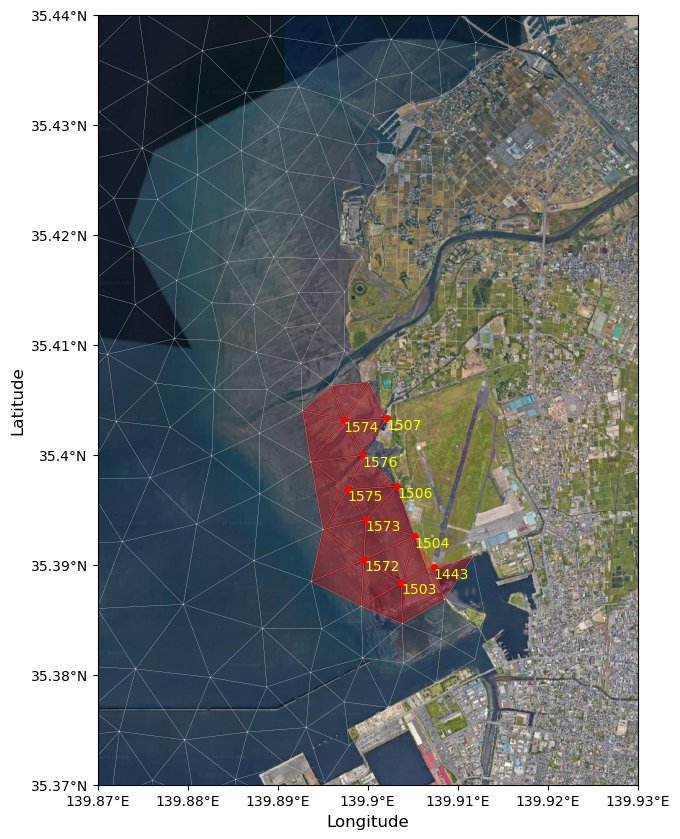

Number of triangular elements: 23
Each triangle contributes to the total area of 2,039,705 m²
Figure saved to PNG/nodes_with_polygons.png


In [12]:
# Get triangle polygons for visualization
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Get element boundaries as polygons using the loader
polygons_data = loader.get_node_element_boundaries(
    display_nodes, 
    index_base=1, 
    return_as="polygons"
)

def plot_with_filled_triangles(ax):
    """Display nodes with filled triangular elements."""
    # Add node markers and numbers
    pp_node_num(ax)
    
    # Create polygon patches for each triangle
    patches = []
    for poly_coords in polygons_data:
        # Check if polygon is within bounds
        if opts_with_polygons.xlim and opts_with_polygons.ylim:
            xs = [p[0] for p in poly_coords]
            ys = [p[1] for p in poly_coords]
            
            # Simple bounds check
            if (max(xs) < opts_with_polygons.xlim[0] or 
                min(xs) > opts_with_polygons.xlim[1] or
                max(ys) < opts_with_polygons.ylim[0] or 
                min(ys) > opts_with_polygons.ylim[1]):
                continue
        
        # Transform coordinates if using cartopy
        if hasattr(ax, 'projection'):
            import cartopy.crs as ccrs
            transformed = ax.projection.transform_points(
                ccrs.PlateCarree(),
                np.array([p[0] for p in poly_coords]),
                np.array([p[1] for p in poly_coords])
            )
            poly_coords_transformed = [(x, y) for x, y in transformed[:, :2]]
            patches.append(Polygon(poly_coords_transformed))
        else:
            patches.append(Polygon(poly_coords))
    
    # Create patch collection with semi-transparent red fill
    if patches:
        pc = PatchCollection(patches, 
                           facecolor='red', 
                           edgecolor='darkred',
                           alpha=0.3, 
                           linewidth=1.5)
        ax.add_collection(pc)

# Plot options for polygon view
opts_with_polygons = FvcomPlotOptions(
    figsize=(12, 10),
    add_tiles=True,
    tile_provider=tile_provider_hires,
    mesh_color="lightgray",
    mesh_linewidth=0.2,
    title=f"Node Locations with Filled Triangular Elements",
    xlim=xlim_node_num,
    ylim=ylim_node_num,
)

# Create the plot
ax_polygons = plotter.plot_2d(
    da=None, 
    post_process_func=plot_with_filled_triangles, 
    opts=opts_with_polygons
)

# Add high-res tiles
if hasattr(ax_polygons, 'add_image'):
    for artist in ax_polygons.artists[:]:
        artist.remove()
    ax_polygons.add_image(tile_provider_hires, 15)

# Save figure
ax_polygons.figure.savefig(output_dir / "nodes_with_polygons.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Number of triangular elements: {len(polygons_data)}")
print(f"Each triangle contributes to the total area of {area_m2:,.0f} m²")
print("Figure saved to PNG/nodes_with_polygons.png")

## 11. Visualize Median-Dual Control Volumes

Display the FVCOM median-dual control volume polygons for selected nodes. These are the actual areas used in FVCOM physics calculations.

In [ ]:
# Get median-dual control volume polygons for visualization
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import cartopy.crs as ccrs

# Get control volume polygons from the loader
control_volumes = loader.get_node_control_volumes(display_nodes, index_base=1)

print(f"Retrieved {len(control_volumes)} control volume polygons")

def plot_with_control_volumes(ax):
    """Display nodes with their median-dual control volume polygons."""
    # Add node markers and numbers
    pp_node_num(ax)
    
    # Create polygon patches for each control volume
    patches = []
    for poly_coords in control_volumes:
        if len(poly_coords) < 3:
            continue
            
        # Check if polygon is within bounds
        if opts_cv.xlim and opts_cv.ylim:
            xs = [p[0] for p in poly_coords]
            ys = [p[1] for p in poly_coords]
            
            # Simple bounds check
            if (max(xs) < opts_cv.xlim[0] - 0.01 or 
                min(xs) > opts_cv.xlim[1] + 0.01 or
                max(ys) < opts_cv.ylim[0] - 0.01 or 
                min(ys) > opts_cv.ylim[1] + 0.01):
                continue
        
        # Transform coordinates if using cartopy
        if hasattr(ax, 'projection'):
            transformed = ax.projection.transform_points(
                ccrs.PlateCarree(),
                np.array([p[0] for p in poly_coords]),
                np.array([p[1] for p in poly_coords])
            )
            poly_coords_transformed = [(x, y) for x, y in transformed[:, :2]]
            patches.append(Polygon(poly_coords_transformed))
        else:
            patches.append(Polygon(poly_coords))
    
    # Create patch collection with semi-transparent blue fill
    # Blue indicates these are control volumes (different from red triangles)
    if patches:
        pc = PatchCollection(patches, 
                           facecolor='blue', 
                           edgecolor='darkblue',
                           alpha=0.3, 
                           linewidth=1.5,
                           zorder=3)
        ax.add_collection(pc)
        print(f"Added {len(patches)} control volume patches to plot")

# Plot options for control volume view
opts_cv = FvcomPlotOptions(
    figsize=(12, 10),
    add_tiles=True,
    tile_provider=tile_provider_hires,
    mesh_color="lightgray",
    mesh_linewidth=0.2,
    title=f"Median-Dual Control Volumes (FVCOM Physics)",
    xlim=xlim_node_num,
    ylim=ylim_node_num,
)

# Create the plot
ax_cv = plotter.plot_2d(
    da=None, 
    post_process_func=plot_with_control_volumes, 
    opts=opts_cv
)

# Add high-res tiles
if hasattr(ax_cv, 'add_image'):
    for artist in ax_cv.artists[:]:
        artist.remove()
    ax_cv.add_image(tile_provider_hires, 15)

# Save figure
ax_cv.figure.savefig(output_dir / "nodes_with_control_volumes.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nNumber of control volume polygons: {len(control_volumes)}")
print(f"Total control volume area: {median_dual_area_m2:,.0f} m²")
print(f"Compare to triangle area: {triangle_area_m2:,.0f} m²")
print(f"Ratio (CV/triangle): {median_dual_area_m2/triangle_area_m2:.4f}")
print("\nNote: Blue polygons show median-dual control volumes (correct for FVCOM)")
print("      Red polygons (previous section) show triangular elements (geometric only)")
print("\nFigure saved to PNG/nodes_with_control_volumes.png")